In [1]:
%load_ext pycodestyle_magic
%flake8_on

In [2]:
%matplotlib inline

import gc
from time import time
import datetime
import multiprocessing
import warnings


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp


from tqdm import tqdm, tqdm_notebook
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, TimeSeriesSplit, train_test_split
from sklearn.metrics import roc_auc_score

from reduce_mem_usage import reduce_mem_usage

In [3]:
warnings.simplefilter('ignore')
sns.set()

In [5]:
files = ['/input/test_identity.csv',
         '/input/test_transaction.csv',
         '/input/train_identity.csv',
         '/input/train_transaction.csv',
         '/input/sample_submission.csv']

In [6]:
train_transaction = pd.read_csv('input/train_transaction.csv',
                                index_col='TransactionID')
test_transaction = pd.read_csv('input/test_transaction.csv',
                               index_col='TransactionID')

train_identity = pd.read_csv('input/train_identity.csv',
                             index_col='TransactionID')
test_identity = pd.read_csv('input/test_identity.csv',
                            index_col='TransactionID')

sample_submission = pd.read_csv('input/sample_submission.csv',
                                index_col='TransactionID')

In [7]:
train = pd.merge(train_transaction, train_identity,
                 on='TransactionID', how='left')
test = pd.merge(test_transaction, test_identity,
                on='TransactionID', how='left')

del test_identity, test_transaction, train_identity, train_transaction
gc.collect()

1210

In [8]:
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

Mem. usage decreased to 648.22 Mb (66.8% reduction)
Mem. usage decreased to 563.43 Mb (66.3% reduction)


# Feature engineering

In [9]:
# We get back the Day, Month, and Week 
# from the estimated start time of the data
START_DATE = datetime.datetime.strptime('2017-11-30', '%Y-%m-%d')


def add_seconds(x):
    return START_DATE + datetime.timedelta(seconds=x)


for df in [train, test]:
    # Temporary
    df['DT'] = df['TransactionDT'].apply(add_seconds)
    df['DT_M'] = (df['DT'].dt.year - 2017) * 12 + df['DT'].dt.month
    df['DT_W'] = (df['DT'].dt.year - 2017) * 52 + df['DT'].dt.weekofyear
    df['DT_D'] = (df['DT'].dt.year - 2017) * 365 + df['DT'].dt.dayofyear

    df['DT_hour'] = df['DT'].dt.hour
    df['DT_day_week'] = df['DT'].dt.dayofweek
    df['DT_day'] = df['DT'].dt.day

# Test different options for this
    # D9 column
    df['D9_isnull'] = np.where(df['D9'].isna(), 0, 1)

In [10]:
# Adding Counts (a way to encode categiral variables)
cards = ['card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'id_36']
for feature in cards:
    train[feature + '_count_full'] = train[feature].map(
        pd.concat(
            [train[feature],
             test[feature]],
            ignore_index=True).value_counts(dropna=False))

    test[feature + '_count_full'] = test[feature].map(
        pd.concat([train[feature],
                   test[feature]],
                  ignore_index=True).value_counts(dropna=False))

# Encoding - count encoding separately for train and test
for feature in ['id_01', 'id_31', 'id_33', 'id_36']:
    train[feature + '_count_dist'] = train[feature].map(
        train[feature].value_counts(dropna=False))
    test[feature + '_count_dist'] = test[feature].map(
        test[feature].value_counts(dropna=False))

In [11]:
# Sum the M columns, and their NAs
# i.e, if all M columns are True, the sum will be 8
i_cols = ['M1', 'M2', 'M3', 'M5', 'M6', 'M7', 'M8', 'M9']


def replaceTF(x):
    '''Replace T with 1 and F with 0 '''
    if x == 'T':
        return 1
    elif x == 'F':
        return 0
    else:
        return np.nan


for col in i_cols:
    train[col] = train[col].apply(replaceTF)
    test[col] = test[col].apply(replaceTF)

for df in [train, test]:
    df['M_sum'] = df[i_cols].sum(axis=1).astype(np.int8)
    df['M_na'] = df[i_cols].isna().sum(axis=1).astype(np.int8)

In [12]:
TARGET = 'isFraud'

In [13]:
# Target encoding, another way to encode categorical vars
categorical_cols = train.select_dtypes('category').columns
for col in categorical_cols:
    print(col)

    temp_dict = train.groupby([col])[TARGET].agg(['mean'])
    temp_dict = temp_dict.reset_index()
    temp_dict = temp_dict.rename(columns={'mean': col+'_target_mean'})
    temp_dict.index = temp_dict[col].values
    temp_dict = temp_dict[col+'_target_mean'].to_dict()

    train[col+'_target_mean'] = train[col].map(temp_dict)
    test[col+'_target_mean'] = test[col].map(temp_dict)

In [14]:
# Try to regroup some variables to find back the users
train['uid'] = train['card1'].astype(str) + '_' + \
    train['card2'].astype(str)
test['uid'] = test['card1'].astype(str) + '_' + \
    test['card2'].astype(str)

train['uid2'] = train['uid'].astype(str) + '_' + \
    train['card3'].astype(str) + '_' + train['card4'].astype(str)
test['uid2'] = test['uid'].astype(str) + '_' + \
    test['card3'].astype(str) + '_' + test['card4'].astype(str)

train['uid3'] = train['uid2'].astype(str) + '_' + \
    train['addr1'].astype(str) + '_' + train['addr2'].astype(str)
test['uid3'] = test['uid2'].astype(str) + '_' + \
    test['addr1'].astype(str) + '_' + test['addr2'].astype(str)


# Check if the Transaction Amount is present in the other set (train vs. test)
# In our dialog with a model we are telling to trust or not to these values
train['TransactionAmt_check'] = np.where(
    train['TransactionAmt'].isin(test['TransactionAmt']),
    1, 0)
train['ProductCD_check'] = np.where(
    train['ProductCD'].isin(test['ProductCD']),
    1, 0)
test['TransactionAmt_check'] = np.where(
    test['TransactionAmt'].isin(train['TransactionAmt']),
    1, 0)
test['ProductCD_check'] = np.where(
    test['ProductCD'].isin(train['ProductCD']),
    1, 0)

In [17]:
# Std and Mean TransactionAMT per item that helps find User

i_cols = ['card1', 'card2', 'card3', 'card5', 'uid', 'uid2', 'uid3']

for col in i_cols:
    for agg_type in ['mean', 'std']:
        new_col_name = col + '_TransactionAmt_' + agg_type
        temp_df = pd.concat([train[[col, 'TransactionAmt']],
                             test[[col, 'TransactionAmt']]])
        temp_df = temp_df.groupby([col])['TransactionAmt'].agg(
            [agg_type]).reset_index().rename(
            columns={agg_type: new_col_name})

        temp_df.index = list(temp_df[col])
        temp_df = temp_df[new_col_name].to_dict()

        train[new_col_name] = train[col].map(temp_df)
        test[new_col_name] = test[col].map(temp_df)

# We can also take the log of Transaction AMT
train['TransactionAmt_log'] = np.log1p(train['TransactionAmt'])
test['TransactionAmt_log'] = np.log1p(test['TransactionAmt'])


# Make similar aggregations with ProductCD
cols_of_interest = ['card1', 'card2', 'card3', 'card5', 'addr1', 'addr2',
                    'dist2', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8',
                    'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'TransactionAmt',
                    'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9',
                    'D10', 'D13', 'D14', 'D15', 'uid', 'uid2', 'uid3']
for col in cols_of_interest:
    for agg_type in ['mean', 'std']:
        if (train[col].dtypes != 'object'):
            new_col_name = col + '_ProductCD_' + agg_type
            temp_dict = train.groupby(['ProductCD'])[col].agg(
                [agg_type]).reset_index().rename(
                columns={agg_type: new_col_name})
            temp_dict.index = temp_dict[new_col_name].values
            temp_dict = temp_dict[new_col_name].to_dict()

            train[new_col_name] = train[col].map(temp_dict)
            test[new_col_name] = test[col].map(temp_dict)

In [19]:
# Text mining on emaildomains
p = 'P_emaildomain'
r = 'R_emaildomain'
unknown = 'email_not_provided'

for df in [train, test]:
    df[p] = df[p].astype(str)
    df[p] = df[p].fillna(unknown)
    df[r] = df[r].astype(str)
    df[r] = df[r].fillna(unknown)

    # Check if P_emaildomain matches R_emaildomain
    df['email_check'] = np.where((df[p] == df[r]) & (df[p] != unknown), 1, 0)

    df[p+'_prefix'] = df[p].apply(lambda x: x.split('.')[0])
    df[r+'_prefix'] = df[r].apply(lambda x: x.split('.')[0])

In [20]:
# Device and versions (apparently fraudsters always have updated software)
for df in [train, test]:
    for col in ['DeviceInfo', 'id_30', 'id_31']:
        df[col] = df[col].astype(str).fillna('unknown_device').str.lower()
        df[col+'_device'] = df[col].apply(
            lambda x: ''.join([i for i in x if i.isalpha()])
        )
        df[col+'_version'] = df[col].apply(
            lambda x: ''.join([i for i in x if i.isnumeric()])
        )

In [22]:
# Frequency encoding
i_cols = ['card1', 'card2', 'card3', 'card5', 'C1', 'C2', 'C3', 'C4', 'C5',
          'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14',
          'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'addr1', 'addr2', 'dist1',
          'dist2', 'P_emaildomain', 'R_emaildomain', 'DeviceInfo', 'D1', 'D2',
          'DeviceInfo_device', 'DeviceInfo_version', 'id_30', 'id_30_device',
          'id_30_version', 'id_31_device', 'id_33', 'uid', 'uid2', 'uid3']

for col in i_cols:
    temp_df = pd.concat([train[[col]], test[[col]]])
    fq_encode = temp_df[col].value_counts(dropna=False).to_dict()
    train[col+'_fq_enc'] = train[col].map(fq_encode)
    test[col+'_fq_enc'] = test[col].map(fq_encode)

# Same stuff with other variables
for col in ['DT_M', 'DT_W', 'DT_D']:
    temp_df = pd.concat([train[[col]], test[[col]]])
    fq_encode = temp_df[col].value_counts().to_dict()

    train[col+'_total'] = train[col].map(fq_encode)
    test[col+'_total'] = test[col].map(fq_encode)

In [23]:
# frequency encoding of a mix between uid and periods
# Test different options for this (different uids ?)

periods = ['DT_M', 'DT_W', 'DT_D']
i_cols = ['uid']
for period in periods:
    for col in i_cols:
        new_column = col + '_' + period

        temp_df = pd.concat([train[[col, period]], test[[col, period]]])
        temp_df[new_column] = temp_df[col].astype(str) + '_' + \
            (temp_df[period]).astype(str)
        fq_encode = temp_df[new_column].value_counts().to_dict()

        train[new_column] = (train[col].astype(str) + '_' +
                             train[period].astype(str)).map(fq_encode)
        test[new_column] = (test[col].astype(str) + '_' +
                            test[period].astype(str)).map(fq_encode)

        train[new_column] /= train[period + '_total']
        test[new_column] /= test[period + '_total']

In [ ]:
df['DeviceInfo'].str.split()

In [33]:
%flake8_off

# The two following cells don't strictly comply with PEP8
# But https://www.python.org/dev/peps/pep-0008/#a-foolish-consistency-is-the-hobgoblin-of-little-minds


# Group all device names in their constructor names
def id_split(dataframe):
    dataframe['device_name'] = dataframe['DeviceInfo'].str.split('/', expand=True)[0]
    dataframe['device_version'] = dataframe['DeviceInfo'].str.split('/', expand=True)[1]

    dataframe['OS_id_30'] = dataframe['id_30'].str.split(' ', expand=True)[0]
    dataframe['version_id_30'] = dataframe['id_30'].str.split(' ', expand=True)[1]

    dataframe['browser_id_31'] = dataframe['id_31'].str.split(' ', expand=True)[0]
    dataframe['version_id_31'] = dataframe['id_31'].str.split(' ', expand=True)[1]

    dataframe['screen_width'] = dataframe['id_33'].str.split('x', expand=True)[0]
    dataframe['screen_height'] = dataframe['id_33'].str.split('x', expand=True)[1]

    idx = dataframe['device_name'].str.contains('SM', na=False)
    dataframe.loc[idx, 'device_name'] = 'Samsung'
    idx = dataframe['device_name'].str.contains('SAMSUNG', na=False)
    dataframe.loc[idx, 'device_name'] = 'Samsung'
    idx = dataframe['device_name'].str.contains('GT-', na=False)
    dataframe.loc[idx, 'device_name'] = 'Samsung'
    idx = dataframe['device_name'].str.contains('Moto G', na=False)
    dataframe.loc[idx, 'device_name'] = 'Motorola'
    idx = dataframe['device_name'].str.contains('Moto', na=False)
    dataframe.loc[idx, 'device_name'] = 'Motorola'
    idx = dataframe['device_name'].str.contains('moto', na=False)
    dataframe.loc[idx, 'device_name'] = 'Motorola'
    idx = dataframe['device_name'].str.contains('LG-', na=False)
    dataframe.loc[idx, 'device_name'] = 'LG'
    idx = dataframe['device_name'].str.contains('rv:', na=False)
    dataframe.loc[idx, 'device_name'] = 'RV'
    idx = dataframe['device_name'].str.contains('HUAWEI', na=False)
    dataframe.loc[idx, 'device_name'] = 'Huawei'
    idx = dataframe['device_name'].str.contains('ALE-', na=False)
    dataframe.loc[idx, 'device_name'] = 'Huawei'
    idx = dataframe['device_name'].str.contains('-L', na=False)
    dataframe.loc[idx, 'device_name'] = 'Huawei'
    idx = dataframe['device_name'].str.contains('Blade', na=False)
    dataframe.loc[idx, 'device_name'] = 'ZTE'
    idx = dataframe['device_name'].str.contains('BLADE', na=False)
    dataframe.loc[idx, 'device_name'] = 'ZTE'
    idx = dataframe['device_name'].str.contains('Linux', na=False)
    dataframe.loc[idx, 'device_name'] = 'Linux'
    idx = dataframe['device_name'].str.contains('XT', na=False)
    dataframe.loc[idx, 'device_name'] = 'Sony'
    idx = dataframe['device_name'].str.contains('HTC', na=False)
    dataframe.loc[idx, 'device_name'] = 'HTC'
    idx = dataframe['device_name'].str.contains('ASUS', na=False)
    dataframe.loc[idx, 'device_name'] = 'Asus'

    # If less than 200 appearances, set to Others
    mask = dataframe.device_name.value_counts() < 200
    idx = dataframe.device_name.isin(
        dataframe.device_name.value_counts()[mask].index
    )
    dataframe.loc[idx, 'device_name'] = "Others"
    dataframe['had_id'] = 1
    gc.collect()

    return dataframe


train = id_split(train)
test = id_split(test)

In [34]:
train['id_02_to_mean_card1'] = train['id_02'] / train.groupby(['card1'])['id_02'].transform('mean')
train['id_02_to_mean_card4'] = train['id_02'] / train.groupby(['card4'])['id_02'].transform('mean')
train['id_02_to_std_card1'] = train['id_02'] / train.groupby(['card1'])['id_02'].transform('std')
train['id_02_to_std_card4'] = train['id_02'] / train.groupby(['card4'])['id_02'].transform('std')

test['id_02_to_mean_card1'] = test['id_02'] / test.groupby(['card1'])['id_02'].transform('mean')
test['id_02_to_mean_card4'] = test['id_02'] / test.groupby(['card4'])['id_02'].transform('mean')
test['id_02_to_std_card1'] = test['id_02'] / test.groupby(['card1'])['id_02'].transform('std')
test['id_02_to_std_card4'] = test['id_02'] / test.groupby(['card4'])['id_02'].transform('std')

train['D15_to_mean_card1'] = train['D15'] / train.groupby(['card1'])['D15'].transform('mean')
train['D15_to_mean_card4'] = train['D15'] / train.groupby(['card4'])['D15'].transform('mean')
train['D15_to_std_card1'] = train['D15'] / train.groupby(['card1'])['D15'].transform('std')
train['D15_to_std_card4'] = train['D15'] / train.groupby(['card4'])['D15'].transform('std')

test['D15_to_mean_card1'] = test['D15'] / test.groupby(['card1'])['D15'].transform('mean')
test['D15_to_mean_card4'] = test['D15'] / test.groupby(['card4'])['D15'].transform('mean')
test['D15_to_std_card1'] = test['D15'] / test.groupby(['card1'])['D15'].transform('std')
test['D15_to_std_card4'] = test['D15'] / test.groupby(['card4'])['D15'].transform('std')

train['D15_to_mean_addr1'] = train['D15'] / train.groupby(['addr1'])['D15'].transform('mean')
train['D15_to_mean_card4'] = train['D15'] / train.groupby(['card4'])['D15'].transform('mean')
train['D15_to_std_addr1'] = train['D15'] / train.groupby(['addr1'])['D15'].transform('std')
train['D15_to_std_card4'] = train['D15'] / train.groupby(['card4'])['D15'].transform('std')

test['D15_to_mean_addr1'] = test['D15'] / test.groupby(['addr1'])['D15'].transform('mean')
test['D15_to_mean_card4'] = test['D15'] / test.groupby(['card4'])['D15'].transform('mean')
test['D15_to_std_addr1'] = test['D15'] / test.groupby(['addr1'])['D15'].transform('std')
test['D15_to_std_card4'] = test['D15'] / test.groupby(['card4'])['D15'].transform('std')

In [35]:
%flake8_on
# New feature - decimal part of the transaction amount.
decimal = (train['TransactionAmt'] - train['TransactionAmt'].astype(int))
train['TransactionAmt_decimal'] = (decimal * 1000).astype(int)
decimal = (test['TransactionAmt'] - test['TransactionAmt'].astype(int))
test['TransactionAmt_decimal'] = (decimal * 1000).astype(int)

In [41]:
# combination of categorical variables
for feature in ['id_02__id_20', 'id_02__D8', 'D11__DeviceInfo',
                'DeviceInfo__P_emaildomain', 'P_emaildomain__C2',
                'card2__dist1', 'card1__card5', 'card2__id_20',
                'card5__P_emaildomain', 'addr1__card1', 'id_02__id_14',
                'id_14__id_20', 'id_02__id_17', 'id_14__id_17',
                'id_17__id_20', 'id_02__id_19', 'id_14__id_19',
                'id_17__id_19', 'id_19__id_20'
                ]:

    f1, f2 = feature.split('__')
    train[feature] = train[f1].astype(str) + '_' + train[f2].astype(str)
    test[feature] = test[f1].astype(str) + '_' + test[f2].astype(str)

    le = LabelEncoder()
    possible_values = list(train[feature].astype(str).values) + \
        list(test[feature].astype(str).values)
    le.fit(possible_values)
    train[feature] = le.transform(list(train[feature].astype(str).values))
    test[feature] = le.transform(list(test[feature].astype(str).values))

We are worried that some features might lose informative power as the timeframe changes. So we'd like to know which feature has values that change a lot between train and test set. We use the following test to do just that

In [44]:
def get_diff_columns(train_df, test_df, show_plots=True,
                     show_all=False, threshold=0.01):
    """"Use KS to estimate columns where distributions
    differ a lot from each other"""
    numerics = ['int8', 'int16', 'int32', 'int64',
                'float16', 'float32', 'float64']
    # Find the columns where the distributions are very different
    diff_data = []
    for col in tqdm(test_df.columns):
        if (test_df[col].dtypes in numerics) and (col != 'TransactionID'):
            statistic, pvalue = ks_2samp(
                train_df[col].values,
                test_df[col].values)
            if pvalue == 0:
                diff_data.append({'feature': col, 'p': np.round(pvalue, 5),
                                  'statistic': np.round(np.abs(statistic), 2)
                                  })

    # Put the differences into a dataframe
    diff_df = pd.DataFrame(diff_data).sort_values(by='statistic',
                                                  ascending=False)
    return diff_df


diff_df = get_diff_columns(train, test)

100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [02:26<00:00,  3.62it/s]


In [45]:
# When the statistic is higher than 0.15 (with a p-value of 0)
# we can consider it changes too much from train to test
todel = diff_df[diff_df['statistic'] > 0.15]['feature'].tolist()
todel

['TransactionDT',
 'DT_M',
 'DT_W',
 'DT_D',
 'id_33_count_dist',
 'DT_M_total',
 'id_01_count_dist',
 'id_31_count_dist',
 'id_36_count_dist',
 'D15_to_std_card4',
 'D15_to_std_addr1',
 'DT_W_total',
 'D15_to_std_card1',
 'DT_D_total']

In [46]:
train = train.drop(todel, axis=1)
test = test.drop(todel, axis=1)
del(diff_df)

In [47]:
for col in list(train):
    if train[col].dtype == 'O':
        train[col] = train[col].fillna('unseen_before_label')
        test[col] = test[col].fillna('unseen_before_label')
        
        train[col] = train[col].astype(str)
        test[col] = test[col].astype(str)
        
        le = LabelEncoder()
        le.fit(list(train[col]) + list(test[col]))
        train[col] = le.transform(train[col])
        test[col] = le.transform(test[col])
        
        train[col] = train[col].astype('category')
        test[col] = test[col].astype('category')

5:1: W293 blank line contains whitespace
8:1: W293 blank line contains whitespace
13:1: W293 blank line contains whitespace


In [49]:
rm_cols = [
    'TransactionID', 'TransactionDT',  # These columns are pure noise right now
    TARGET,                            # Not target in features))
    'uid', 'uid2', 'uid3',             # Our new client uID -> very noisy data
    'bank_type',                       # Victims bank could differ by time
    'DT', 'DT_M', 'DT_W', 'DT_D',      # Temporary Variables
    'DT_hour', 'DT_day_week', 'DT_day',
    'DT_D_total', 'DT_W_total', 'DT_M_total',
    'id_30', 'id_31', 'id_33',
]

In [50]:
features_columns = [col for col in list(train) if col not in rm_cols]

In [51]:
# The June month drops entirely
train['random_noise'] = np.random.randn(len(train))
print(train['DT'].max())
print(test['DT'].min())
# So we need to get rid of April and keep May as validation set
X_train = train[train['DT'] <= '2018-03-31']
y_train = X_train[TARGET]
X_train = X_train[features_columns]
X_valid = train[(train['DT'] >= '2018-05-01')]
y_valid = X_valid[TARGET]
X_valid = X_valid[features_columns]

2018-05-31 23:58:51
2018-07-01 00:00:24


In [54]:
lgb_params = {
                    'objective': 'binary',
                    'boosting_type': 'gbdt',
                    'metric': 'auc',
                    'n_jobs': -1,
                    'learning_rate': 0.01,
                    'num_leaves': 496,
                    'max_depth': -1,
                    'min_data_in_leaf': 50,
                    'tree_learner': 'serial',
                    'colsample_bytree': 0.7,
                    'subsample_freq': 1,
                    'subsample': 0.7,
                    'n_estimators': 800,
                    'max_bin': 255,
                    'verbose': -1,
                    'seed': 24,
                    'early_stopping_rounds': 100,
                } 

In [29]:
tr_data = lgb.Dataset(X_train, label = y_train)
vl_data = lgb.Dataset(X_valid, label = y_valid)  
        
estimator = lgb.train(
                lgb_params,
                tr_data,
                valid_sets = [tr_data, vl_data],
                verbose_eval = 100)

Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.962848	valid_1's auc: 0.895265
[400]	training's auc: 0.998079	valid_1's auc: 0.918299
[500]	training's auc: 0.999401	valid_1's auc: 0.919544
[800]	training's auc: 0.999987	valid_1's auc: 0.92052
Did not meet early stopping. Best iteration is:
[800]	training's auc: 0.999987	valid_1's auc: 0.92052


# Try differentiating train and valid

This is usually called "adversarial training", and the goal is to see whether a model can find correctly if an entry/row comes from the train or the validation set.

When this is done, if the model is good, it means some variables are useful in predicting whether a row is in January-May or in June. We drop those vars and see if we gain some generalisation compared to the baseline above.

In [57]:
# Start by creating a new column and set it to 0
train['isValid'] = 0
# If a particular row is part of the validation set, set it to 1
train.loc[X_valid.index, 'isValid'] = 1
y_isvalid = train['isValid']
train.drop('isValid', axis=1, inplace=True)

# variable names start being messy here,
# but it's just a train/valid split with a different learning goal
train_isvalid = train.copy()
valid_isvalid = train_isvalid.sample(frac=0.2)
train_isvalid.drop(valid_isvalid.index, inplace=True)
assert len(train_isvalid) + len(valid_isvalid) == len(train)

y_train_isvalid = y_isvalid[train_isvalid.index]
y_valid_isvalid = y_isvalid[valid_isvalid.index]
assert len(y_train_isvalid) + len(y_valid_isvalid) == len(y_isvalid)

In [58]:
tr_data = lgb.Dataset(train_isvalid[features_columns],
                      label=y_train_isvalid)
vl_data = lgb.Dataset(valid_isvalid[features_columns],
                      label=y_valid_isvalid)

estimator = lgb.train(
                lgb_params,
                tr_data,
                valid_sets=[tr_data, vl_data],
                verbose_eval=100)

C:\Users\benjamin.dubreu\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\benjamin.dubreu\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.954122	valid_1's auc: 0.948157
[200]	training's auc: 0.975627	valid_1's auc: 0.969815
[300]	training's auc: 0.991778	valid_1's auc: 0.98831
[400]	training's auc: 0.997537	valid_1's auc: 0.995683
[500]	training's auc: 0.999001	valid_1's auc: 0.997227
[600]	training's auc: 0.999564	valid_1's auc: 0.998043
[700]	training's auc: 0.999822	valid_1's auc: 0.998625
[800]	training's auc: 0.999924	valid_1's auc: 0.998919
Did not meet early stopping. Best iteration is:
[800]	training's auc: 0.999924	valid_1's auc: 0.998919


4:45: W291 trailing whitespace
5:1: W293 blank line contains whitespace
9:27: E251 unexpected spaces around keyword / parameter equals
9:29: E251 unexpected spaces around keyword / parameter equals
10:29: E251 unexpected spaces around keyword / parameter equals
10:31: E251 unexpected spaces around keyword / parameter equals


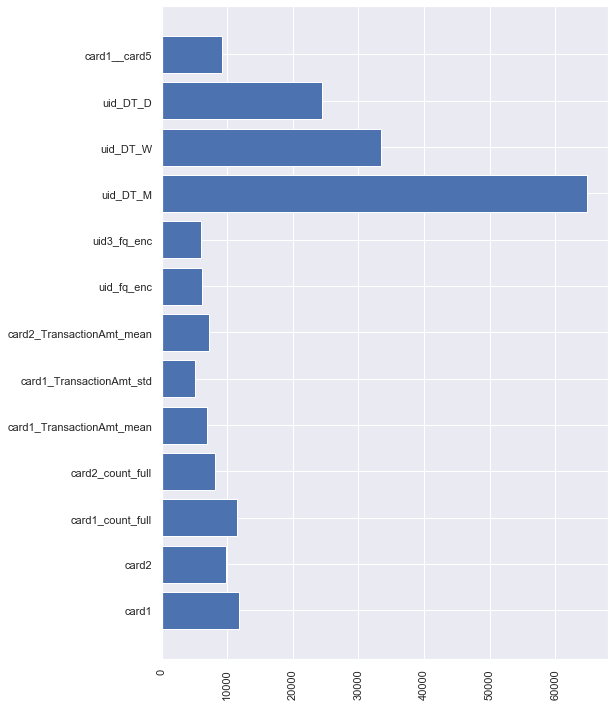

In [60]:
plt.figure(figsize=(8, 12))

mask = (estimator.feature_importance() > 5000)
feature_names = np.array(estimator.feature_name())[mask]
feature_importances = estimator.feature_importance()[mask]
plt.barh(feature_names, feature_importances)
plt.xticks(rotation=90)
plt.show()

In [61]:
np.array(estimator.feature_name())[mask]

array(['card1', 'card2', 'card1_count_full', 'card2_count_full',
       'card1_TransactionAmt_mean', 'card1_TransactionAmt_std',
       'card2_TransactionAmt_mean', 'uid_fq_enc', 'uid3_fq_enc',
       'uid_DT_M', 'uid_DT_W', 'uid_DT_D', 'card1__card5'], dtype='<U29')

In [110]:
changing_vars = ['card1', 'card1_count_full', 'uid_DT_M',
                 'uid_DT_W', 'uid_DT_D']
# We drop the most changing vars and see if that has an effet on results 
tr_data = lgb.Dataset(X_train.drop(changing_vars, axis=1), label=y_train)
vl_data = lgb.Dataset(X_valid.drop(changing_vars, axis=1), label=y_valid)  

estimator = lgb.train(
                lgb_params,
                tr_data,
                valid_sets = [tr_data, vl_data],
                verbose_eval = 100)

Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.961737	valid_1's auc: 0.894886
[200]	training's auc: 0.98223	valid_1's auc: 0.907333
[300]	training's auc: 0.993281	valid_1's auc: 0.914879
[400]	training's auc: 0.997704	valid_1's auc: 0.918281
[500]	training's auc: 0.999225	valid_1's auc: 0.91934
[600]	training's auc: 0.999748	valid_1's auc: 0.919381
[700]	training's auc: 0.999917	valid_1's auc: 0.91975
[800]	training's auc: 0.999972	valid_1's auc: 0.919945
Did not meet early stopping. Best iteration is:
[800]	training's auc: 0.999972	valid_1's auc: 0.919945


By removing the variables that help the most to differentiate train from valid, we don't lose much predictive power (close to no effect), but we get a simpler/leaner model AND we take less risk of poor generalization.

# Downsampling

In "DownSampling", we get subset the data the following way:
* we keep all the positive class
* we keep only a subset of the negative class (the more represented)
* we model with that and see if there is a huge drop in AUC
* as long as there isn't, we keep taking smaller and smaller subsets

The goal is to come up with a dataset that takes a few seconds to train, to be able to iterate quickly

In [63]:
pos_class = X_train[y_train == 1]
neg_class = X_train[y_train == 0].sample(frac=0.1, random_state=42)

X_subsample = pd.concat([pos_class, neg_class])
X_subsample = X_subsample.sample(frac=1)  # quick way to shuffle
y_subsample = y_train[X_subsample.index]
assert len(X_subsample) == len(y_subsample)
assert (X_subsample.index == y_subsample.index).all()

In [65]:
tr_data = lgb.Dataset(X_subsample, label=y_subsample)
vl_data = lgb.Dataset(X_valid, label=y_valid)

estimator = lgb.train(
                lgb_params,
                tr_data,
                valid_sets=[tr_data, vl_data],
                verbose_eval=100)

Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.964741	valid_1's auc: 0.892869
[200]	training's auc: 0.980452	valid_1's auc: 0.902851
[300]	training's auc: 0.990791	valid_1's auc: 0.910723
[400]	training's auc: 0.996216	valid_1's auc: 0.914763
[500]	training's auc: 0.998649	valid_1's auc: 0.91637
[600]	training's auc: 0.999596	valid_1's auc: 0.916973
[700]	training's auc: 0.999899	valid_1's auc: 0.917088
[800]	training's auc: 0.99998	valid_1's auc: 0.917053
Did not meet early stopping. Best iteration is:
[800]	training's auc: 0.99998	valid_1's auc: 0.917053


Down to 0.917 from 0.920. We lose only 0.003 AUC by removing 90% of the negative class!

# Try modeling without those columns whose distribution changes

In [66]:
changing_vars = ['card1', 'card1_count_full', 'uid_DT_M',
                 'uid_DT_W', 'uid_DT_D']
tr_data = lgb.Dataset(X_subsample.drop(changing_vars, axis=1),
                      label=y_subsample)
vl_data = lgb.Dataset(X_valid.drop(changing_vars, axis=1),
                      label=y_valid)

estimator = lgb.train(
                lgb_params,
                tr_data,
                valid_sets=[tr_data, vl_data],
                verbose_eval=100) 

Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.963989	valid_1's auc: 0.891756
[200]	training's auc: 0.979771	valid_1's auc: 0.901669
[300]	training's auc: 0.990249	valid_1's auc: 0.910113
[400]	training's auc: 0.995881	valid_1's auc: 0.9152
[500]	training's auc: 0.998462	valid_1's auc: 0.917328
[600]	training's auc: 0.999505	valid_1's auc: 0.918188
[700]	training's auc: 0.999862	valid_1's auc: 0.918426
[800]	training's auc: 0.999967	valid_1's auc: 0.9183
Did not meet early stopping. Best iteration is:
[800]	training's auc: 0.999967	valid_1's auc: 0.9183


When removing the dangerous columns (the ones which behave differently between train and valid), we even get a closer score to our original one, still with very few data!

# Permutation importance

In [67]:
permut_importances = np.zeros_like(X_subsample.columns)
base_roc = roc_auc_score(y_valid, estimator.predict(X_valid))

In [82]:
# for i, col in enumerate(tqdm_notebook(X_subsample.columns)):
#     save = X_valid[col].copy()

#     dtype = X_valid[col].dtype
#     X_valid[col] = np.random.permutation(X_valid[col])
#     X_valid[col] = X_valid[col].astype(dtype)
#     predict_permutation = estimator.predict(X_valid)

#     score_after_permut = roc_auc_score(y_valid, predict_permutation)
#     perte = base_roc - score_after_permut
#     permut_importances[i] = perte * 100
#     X_valid[col] = save

# Use permut_imp_df.csv to get back the results

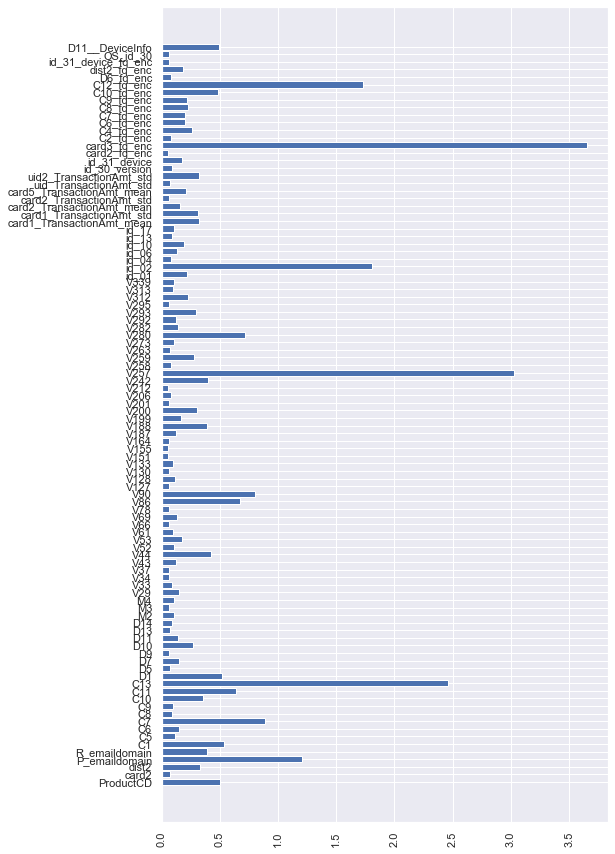

In [71]:
plt.figure(figsize=(8, 15))
mask = permut_importances > 0.05
plt.barh(X_subsample.columns[mask],
         permut_importances[mask])  # 45 variables
plt.xticks(rotation=90)
plt.show()

In [72]:
permut_imp_df = pd.DataFrame()
permut_imp_df['permut_importances'] = permut_importances
permut_imp_df['cols'] = X_subsample.columns.tolist()

In [75]:
permut_imp_df.shape

(616, 2)

In [76]:
permut_imp_df.sort_values('permut_importances',
                          ascending=False).head(10)

,permut_importances,cols
536,3.65083,card3_fq_enc
308,3.02664,V257
26,2.46217,C13
392,1.80809,id_02
549,1.73153,C12_fq_enc
12,1.20611,P_emaildomain
20,0.884187,C7
141,0.804443,V90
331,0.713949,V280
137,0.673641,V86


In [81]:
permut_imp_df.to_csv('permut_imp_df.csv', index=False)

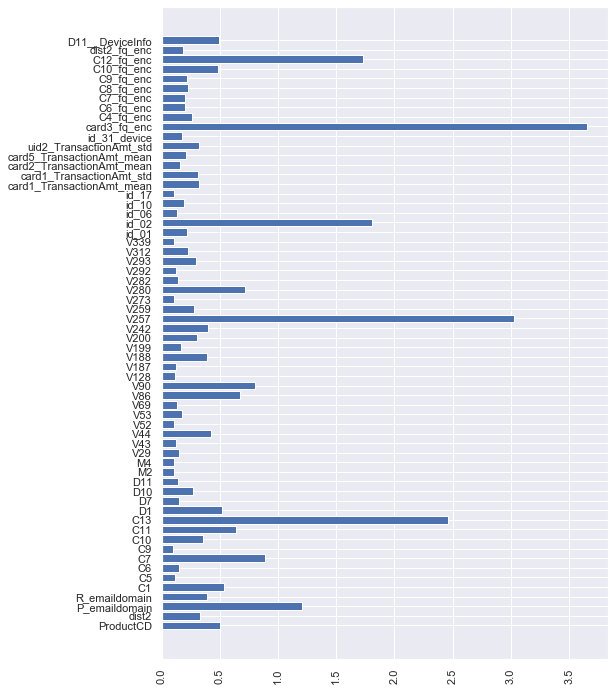

In [79]:
plt.figure(figsize=(8, 12))
mask = permut_importances > 0.1  # 45 variables
plt.barh(X_subsample.columns[mask], permut_importances[mask])
plt.xticks(rotation=90)
plt.show()

<BarContainer object of 14 artists>

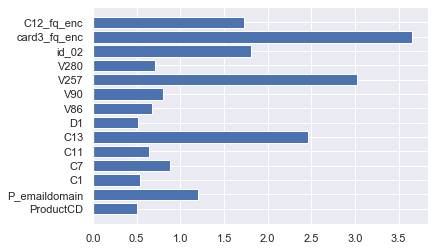

In [80]:
plt.barh(X_subsample.columns[permut_importances > 0.5],
         permut_importances[permut_importances > 0.5]) 

# Try modeling with only subset of vars

In [83]:
mask = permut_importances > 0.05
tr_data = lgb.Dataset(X_subsample[X_subsample.columns[mask]],
                      label=y_subsample)
vl_data = lgb.Dataset(X_valid[X_subsample.columns[mask]],
                      label=y_valid)

estimator = lgb.train(
                lgb_params,
                tr_data,
                valid_sets=[tr_data, vl_data],
                verbose_eval=100)

C:\Users\benjamin.dubreu\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\benjamin.dubreu\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.949745	valid_1's auc: 0.884709
[200]	training's auc: 0.96526	valid_1's auc: 0.890413
[300]	training's auc: 0.977662	valid_1's auc: 0.895854
[400]	training's auc: 0.986151	valid_1's auc: 0.900449
[500]	training's auc: 0.991436	valid_1's auc: 0.902049
[600]	training's auc: 0.994677	valid_1's auc: 0.902434
[700]	training's auc: 0.996618	valid_1's auc: 0.90262
Early stopping, best iteration is:
[698]	training's auc: 0.996591	valid_1's auc: 0.902641


13:26: W291 trailing whitespace


In [86]:
mask = permut_importances > 0.001
tr_data = lgb.Dataset(X_subsample[X_subsample.columns[mask]],
                      label=y_subsample)
vl_data = lgb.Dataset(X_valid[X_subsample.columns[mask]],
                      label=y_valid)

estimator = lgb.train(
                lgb_params,
                tr_data,
                valid_sets=[tr_data, vl_data],
                verbose_eval=100)
# 0.001 seems to be the winner, but it means keeping the vars
# with an AUC increase of 0.00001... likely to overfit valid set
# Turns out not really

Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.96049	valid_1's auc: 0.892366
[200]	training's auc: 0.975675	valid_1's auc: 0.899475
[300]	training's auc: 0.986477	valid_1's auc: 0.906161
[400]	training's auc: 0.993192	valid_1's auc: 0.910631
[500]	training's auc: 0.996841	valid_1's auc: 0.91285
[600]	training's auc: 0.998639	valid_1's auc: 0.913734
[700]	training's auc: 0.999453	valid_1's auc: 0.913437
Early stopping, best iteration is:
[644]	training's auc: 0.999083	valid_1's auc: 0.913834


# From here: move to another notebook. Export data with newly created features

In [90]:
del(train['random_noise'])
train.to_csv('input/train_w_fe.csv', index=False)
test.to_csv('input/test_w_fe.csv', index=False)

# Try modeling with SUM_ID_NANs

In [73]:
id_cols = [col for col in X_subsample.columns if 'id' in col and len(col) < 6]

In [74]:
for col in id_cols:
    X_subsample[col] = X_subsample[col].apply(lambda x: np.nan if x == 'nan' else x)

In [75]:
X_subsample['id_nan_count'] = X_subsample[id_cols].isnull().sum(axis=1) **2
X_valid['id_nan_count'] = X_valid[id_cols].isnull().sum(axis=1) **2

In [76]:
tr_data = lgb.Dataset(X_subsample, label=y_subsample)
vl_data = lgb.Dataset(X_valid, label=y_valid)  
        
estimator = lgb.train(
                lgb_params,
                tr_data,
                valid_sets = [tr_data, vl_data],
                verbose_eval = 100) 

# bestS: 0.912585, 0.915495, 0.9138(this one with random state=42)
# if keep Vcols with 0.15 k2s: 0.917, 0.916
# with id_nans_sum on top: 0.916362

Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.964493	valid_1's auc: 0.892541
[200]	training's auc: 0.980569	valid_1's auc: 0.901461
[300]	training's auc: 0.99086	valid_1's auc: 0.909293
[400]	training's auc: 0.996249	valid_1's auc: 0.914079
[500]	training's auc: 0.998646	valid_1's auc: 0.916374
[600]	training's auc: 0.999571	valid_1's auc: 0.917245
[700]	training's auc: 0.999891	valid_1's auc: 0.916991
Early stopping, best iteration is:
[600]	training's auc: 0.999571	valid_1's auc: 0.917245


# Try adding new features 

In [114]:
# Try to regroup some variables to find back the users
X_subsample['uid'] = X_subsample['card1'].astype(str) + '_' + \
    X_subsample['card2'].astype(str)
X_valid['uid'] = X_valid['card1'].astype(str) + '_' + \
    X_valid['card2'].astype(str)

X_subsample['uid2'] = X_subsample['uid'].astype(str) + '_' + \
    X_subsample['card3'].astype(str) + '_' + X_subsample['card4'].astype(str)
X_valid['uid2'] = X_valid['uid'].astype(str) + '_' + \
    X_valid['card3'].astype(str) + '_' + X_valid['card4'].astype(str)

X_subsample['uid3'] = X_subsample['uid2'].astype(str) + '_' + \
    X_subsample['addr1'].astype(str) + '_' + X_subsample['addr2'].astype(str)
X_valid['uid3'] = X_valid['uid2'].astype(str) + '_' + \
    X_valid['addr1'].astype(str) + '_' + X_valid['addr2'].astype(str)

In [135]:
X_subsample['C1_third_quartile'] = X_subsample.groupby('uid3')['C1'].transform(lambda x: x > x.quantile(0.75))
X_valid['C1_third_quartile'] = X_valid.groupby('uid')['C1'].transform(lambda x: x > x.quantile(0.75))

In [143]:
tr_data = lgb.Dataset(X_subsample[useful_vars.tolist() + ['C1_third_quartile']], label=y_subsample)
vl_data = lgb.Dataset(X_valid[useful_vars.tolist() + ['C1_third_quartile']], label=y_valid)  
        
estimator = lgb.train(
                lgb_params,
                tr_data,
                valid_sets = [tr_data, vl_data],
                verbose_eval = 100) 

#  0.914075 => 0.91819
#  0.909696 => 0.919665

Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.964825	valid_1's auc: 0.895645
[200]	training's auc: 0.980188	valid_1's auc: 0.904202
[400]	training's auc: 0.995891	valid_1's auc: 0.91442
[600]	training's auc: 0.999492	valid_1's auc: 0.91819
[800]	training's auc: 0.999968	valid_1's auc: 0.918997
Did not meet early stopping. Best iteration is:
[800]	training's auc: 0.999968	valid_1's auc: 0.918997


In [ ]:
C_cols = [col for col in useful_vars if col.startswith('C') and '_' not in col]
results_c_cols = {}
for decile in [0.75,0.9]:
    for col in C_cols: 
        X_subsample[col+'_third_quartile'] = X_subsample.groupby('uid3')[col].transform(lambda x: x > x.quantile(decile))
        X_valid[col+'_third_quartile'] = X_valid.groupby('uid3')[col].transform(lambda x: x > x.quantile(decile))
        
        tr_data = lgb.Dataset(X_subsample[useful_vars.tolist()+[col+'_third_quartile']], label=y_subsample)
        vl_data = lgb.Dataset(X_valid[useful_vars.tolist()+[col+'_third_quartile']], label=y_valid)  
            
        estimator3 = lgb.train(
                    lgb_params,
                    tr_data,
                    valid_sets = [tr_data, vl_data],
                    verbose_eval = 0) 
    
        print(decile, col, estimator3.best_score['valid_1']['auc'], estimator3.best_score['valid_1']['auc'] > 0.919665)
        results_c_cols[col+str(decile)] = estimator3.best_score['valid_1']['auc'] - 0.919665
        del(X_subsample[col+'_third_quartile'])
        del(X_valid[col+'_third_quartile'])

C2 0.920006456876584 True
C3 0.9212837185780413 True
C5 0.9193946359351762 False
C6 0.9202151066953561 True
C8 0.9201764721167557 True
C10 0.9203012448201281 True
C11 0.9195494387169016 False
C13 0.9201650888471642 True


In [152]:
C_cols = [col for col in useful_vars if col.startswith('C') and '_' not in col]
results_c_cols = {}
for decile in [0.75,0.9]:
    for col in C_cols: 
        X_subsample[col+'_third_quartile'] = X_subsample.groupby('uid3')[col].transform(lambda x: x > x.quantile(decile))
        X_valid[col+'_third_quartile'] = X_valid.groupby('uid3')[col].transform(lambda x: x > x.quantile(decile))
        
        tr_data = lgb.Dataset(X_subsample[useful_vars.tolist()+[col+'_third_quartile']], label=y_subsample)
        vl_data = lgb.Dataset(X_valid[useful_vars.tolist()+[col+'_third_quartile']], label=y_valid)  
            
        estimator3 = lgb.train(
                    lgb_params,
                    tr_data,
                    valid_sets = [tr_data, vl_data],
                    verbose_eval = 0) 
    
        print(decile, col, estimator3.best_score['valid_1']['auc'], estimator3.best_score['valid_1']['auc'] > 0.919665)
        results_c_cols[col+str(decile)] = estimator3.best_score['valid_1']['auc'] - 0.919665
        del(X_subsample[col+'_third_quartile'])
        del(X_valid[col+'_third_quartile'])

0.75 C1 0.9197192192888848 True
0.75 C2 0.9206407053920135 True
0.75 C5 0.9208753437814464 True
0.75 C8 0.9206131672663296 True
0.75 C9 0.9210218996525451 True
0.75 C10 0.9203944006412059 True
0.75 C11 0.9199956844892612 True
0.75 C13 0.9204102053574613 True
0.75 C14 0.9205487229118785 True
0.9 C2 0.920006456876584 True
0.9 C3 0.9212837185780413 True
0.9 C5 0.9193946359351762 False
0.9 C6 0.9202151066953561 True
0.9 C8 0.9201764721167557 True
0.9 C9 0.9200695937939845 True
0.9 C11 0.9195494387169016 False
0.9 C13 0.9201650888471642 True
0.9 C14 0.9202578498297024 True


In [164]:
# Fonctionne mieux avec les 0.75
for key, value in results_c_cols.items():
    print(key, value*1000)

C10.75 0.054219288884826966
C20.75 0.9757053920135261
C30.75 1.6187185780413005
C50.75 1.2103437814464657
C60.75 0.9994255035182809
C80.75 0.9481672663296248
C90.75 1.3568996525451515
C100.75 0.7294006412059684
C110.75 0.33068448926121263
C130.75 0.7452053574613648
C140.75 0.8837229118785483
C10.9 0.06720798687742668
C20.9 0.34145687658404533
C30.9 1.6187185780413005
C50.9 -0.2703640648237249
C60.9 0.5501066953561562
C80.9 0.511472116755729
C90.9 0.4045937939844979
C100.9 0.6362448201281401
C110.9 -0.11556128309830882
C130.9 0.5000888471642373
C140.9 0.5928498297024243


In [112]:
usecols = pd.read_csv('useful_vars.csv')

In [ ]:
X_subsample['AMT_95'] = X_subsample.groupby('uid3')['TransactionAmt'].transform(lambda x:  x > x.quantile(0.95))
X_subsample['AMT_85'] = X_subsample.groupby('uid3')['TransactionAmt'].transform(lambda x:  x > x.quantile(0.85))
X_subsample['AMT_75'] = X_subsample.groupby('uid3')['TransactionAmt'].transform(lambda x:  x > x.quantile(0.75))
X_subsample['AMT_65'] = X_subsample.groupby('uid3')['TransactionAmt'].transform(lambda x:  x > x.quantile(0.65))
X_subsample['AMT_55'] = X_subsample.groupby('uid3')['TransactionAmt'].transform(lambda x:  x > x.quantile(0.55))
X_subsample['AMT_HH'] = X_subsample['AMT_55'] +X_subsample['AMT_65'] +X_subsample['AMT_75'] +X_subsample['AMT_85'] +X_subsample['AMT_95'] 
del(X_subsample['AMT_95'])
del(X_subsample['AMT_85'])
del(X_subsample['AMT_75'])
del(X_subsample['AMT_65'])
del(X_subsample['AMT_55'])
X_valid['AMT_95'] = X_valid.groupby('uid3')['TransactionAmt'].transform(lambda x:  x > x.quantile(0.95))
X_valid['AMT_85'] = X_valid.groupby('uid3')['TransactionAmt'].transform(lambda x:  x > x.quantile(0.85))
X_valid['AMT_75'] = X_valid.groupby('uid3')['TransactionAmt'].transform(lambda x:  x > x.quantile(0.75))
X_valid['AMT_65'] = X_valid.groupby('uid3')['TransactionAmt'].transform(lambda x:  x > x.quantile(0.65))
X_valid['AMT_55'] = X_valid.groupby('uid3')['TransactionAmt'].transform(lambda x:  x > x.quantile(0.55))
X_valid['AMT_HH'] = X_valid['AMT_55'] +X_valid['AMT_65'] +X_valid['AMT_75'] +X_valid['AMT_85'] +X_valid['AMT_95'] 
del(X_valid['AMT_95'])
del(X_valid['AMT_85'])
del(X_valid['AMT_75'])
del(X_valid['AMT_65'])
del(X_valid['AMT_55'])

In [122]:
tr_data = lgb.Dataset(X_subsample[usecols['cols'].tolist()+['AMT_HH']], label=y_subsample)
vl_data = lgb.Dataset(X_valid[usecols['cols'].tolist()+['AMT_HH']], label=y_valid)  

estimator2 = lgb.train(
                lgb_params,
                tr_data,
                valid_sets = [tr_data, vl_data],
                verbose_eval = 100)

Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.96413	valid_1's auc: 0.895037
[200]	training's auc: 0.979642	valid_1's auc: 0.905219
[300]	training's auc: 0.989962	valid_1's auc: 0.912848
[400]	training's auc: 0.995617	valid_1's auc: 0.917755
[500]	training's auc: 0.998274	valid_1's auc: 0.919999
[600]	training's auc: 0.999402	valid_1's auc: 0.920786
Early stopping, best iteration is:
[580]	training's auc: 0.999255	valid_1's auc: 0.920918


In [123]:
tr_data = lgb.Dataset(X_subsample[usecols['cols'].tolist()], label=y_subsample)
vl_data = lgb.Dataset(X_valid[usecols['cols'].tolist()], label=y_valid)  

estimator2 = lgb.train(
                lgb_params,
                tr_data,
                valid_sets = [tr_data, vl_data],

    verbose_eval = 100)

Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.964518	valid_1's auc: 0.896355
[200]	training's auc: 0.979766	valid_1's auc: 0.905779
[300]	training's auc: 0.990106	valid_1's auc: 0.913728
[400]	training's auc: 0.995657	valid_1's auc: 0.918275
[500]	training's auc: 0.998291	valid_1's auc: 0.920023
[600]	training's auc: 0.999401	valid_1's auc: 0.920812
[700]	training's auc: 0.999826	valid_1's auc: 0.921461
[800]	training's auc: 0.999959	valid_1's auc: 0.921538
Did not meet early stopping. Best iteration is:
[800]	training's auc: 0.999959	valid_1's auc: 0.921538


In [128]:
X_subsample['AMT_95'] = X_subsample.groupby('uid3')['TransactionAmt'].transform(lambda x:  x < x.quantile(0.05))
X_valid['AMT_95'] = X_valid.groupby('uid3')['TransactionAmt'].transform(lambda x:  x < x.quantile(0.05))
tr_data = lgb.Dataset(X_subsample[usecols['cols'].tolist()+['AMT_95']], label=y_subsample)
vl_data = lgb.Dataset(X_valid[usecols['cols'].tolist()+['AMT_95']], label=y_valid)  

estimator2 = lgb.train(
                lgb_params,
                tr_data,
                valid_sets = [tr_data, vl_data],
                verbose_eval = 100)

Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.964171	valid_1's auc: 0.894751
[200]	training's auc: 0.979653	valid_1's auc: 0.905251
[300]	training's auc: 0.98997	valid_1's auc: 0.912885
[400]	training's auc: 0.995598	valid_1's auc: 0.917583
[500]	training's auc: 0.998274	valid_1's auc: 0.919519
[600]	training's auc: 0.999397	valid_1's auc: 0.920243
[700]	training's auc: 0.999825	valid_1's auc: 0.920638
[800]	training's auc: 0.999958	valid_1's auc: 0.920642
Did not meet early stopping. Best iteration is:
[800]	training's auc: 0.999958	valid_1's auc: 0.920642


Int64Index([3128933, 2991817, 3177423, 3047754, 3181795, 2989705, 3392728,
            3315764, 3069830, 3356330,
            ...
            3353014, 3349042, 3350195, 3257291, 3387533, 3356499, 2994892,
            3040207, 3127807, 3077845],
           dtype='int64', name='TransactionID', length=54594)

In [204]:
X_subsample['DT'] = train.loc[X_subsample.index]['DT']
X_subsample['DT_H'] = X_subsample['DT'].dt.hour
X_valid['DT'] = train.loc[X_valid.index]['DT']
X_valid['DT_H'] = X_valid['DT'].dt.hour

X_subsample['DT_H95'] = X_subsample.groupby('uid3')['DT_H'].transform(lambda x:  x > x.quantile(0.95))
X_subsample['DT_H_mean_per_uid'] = X_subsample.groupby('uid3')['DT_H'].transform('mean')
X_subsample['DT_H95_std_per_uid'] = X_subsample.groupby('uid3')['DT_H'].transform('std')

In [205]:
X_subsample['DT_H95'] = X_subsample.groupby('uid3')['DT_H'].transform(lambda x:  x > x.quantile(0.95))
X_valid['DT_H95'] = X_valid.groupby('uid3')['DT_H'].transform(lambda x:  x > x.quantile(0.95))
tr_data = lgb.Dataset(X_subsample[usecols['cols'].tolist()+['DT_H95']], label=y_subsample)
vl_data = lgb.Dataset(X_valid[usecols['cols'].tolist()+['DT_H95']], label=y_valid)  

estimator2 = lgb.train(
                lgb_params,
                tr_data,
                valid_sets = [tr_data, vl_data],
                verbose_eval = 100)

Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.964343	valid_1's auc: 0.895109
[200]	training's auc: 0.979715	valid_1's auc: 0.905294
[300]	training's auc: 0.990008	valid_1's auc: 0.912558
[400]	training's auc: 0.995623	valid_1's auc: 0.917221
[500]	training's auc: 0.998265	valid_1's auc: 0.919516
[600]	training's auc: 0.999395	valid_1's auc: 0.920333
[700]	training's auc: 0.999823	valid_1's auc: 0.920449
Early stopping, best iteration is:
[692]	training's auc: 0.999803	valid_1's auc: 0.920487


In [206]:
X_subsample['DT_H_mean_per_uid'] = X_subsample.groupby('uid3')['DT_H'].transform('mean')
X_valid['DT_H_mean_per_uid'] = X_valid.groupby('uid3')['DT_H'].transform('mean')
tr_data = lgb.Dataset(X_subsample[usecols['cols'].tolist()+['DT_H_mean_per_uid']], label=y_subsample)
vl_data = lgb.Dataset(X_valid[usecols['cols'].tolist()+['DT_H_mean_per_uid']], label=y_valid)  

estimator2 = lgb.train(
                lgb_params,
                tr_data,
                valid_sets = [tr_data, vl_data],
                verbose_eval = 100)

Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.964534	valid_1's auc: 0.894206
[200]	training's auc: 0.980164	valid_1's auc: 0.904134
[300]	training's auc: 0.990495	valid_1's auc: 0.911428
[400]	training's auc: 0.995937	valid_1's auc: 0.916069
[500]	training's auc: 0.99843	valid_1's auc: 0.91806
[600]	training's auc: 0.999463	valid_1's auc: 0.918942
[700]	training's auc: 0.999848	valid_1's auc: 0.919632
[800]	training's auc: 0.999965	valid_1's auc: 0.919961
Did not meet early stopping. Best iteration is:
[800]	training's auc: 0.999965	valid_1's auc: 0.919961


In [207]:
X_subsample['DT_H_std_per_uid'] = X_subsample.groupby('uid3')['DT_H'].transform('std')
X_valid['DT_H_std_per_uid'] = X_valid.groupby('uid3')['DT_H'].transform('std')
tr_data = lgb.Dataset(X_subsample[usecols['cols'].tolist()+['DT_H_std_per_uid']], label=y_subsample)
vl_data = lgb.Dataset(X_valid[usecols['cols'].tolist()+['DT_H_std_per_uid']], label=y_valid)  

estimator2 = lgb.train(
                lgb_params,
                tr_data,
                valid_sets = [tr_data, vl_data],
                verbose_eval = 100)

Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.966781	valid_1's auc: 0.892308
[200]	training's auc: 0.98147	valid_1's auc: 0.900248
[300]	training's auc: 0.990941	valid_1's auc: 0.906536
[400]	training's auc: 0.996049	valid_1's auc: 0.909521
[500]	training's auc: 0.998464	valid_1's auc: 0.911599
[600]	training's auc: 0.999474	valid_1's auc: 0.912769
[700]	training's auc: 0.999851	valid_1's auc: 0.913405


# Most important variables treatment

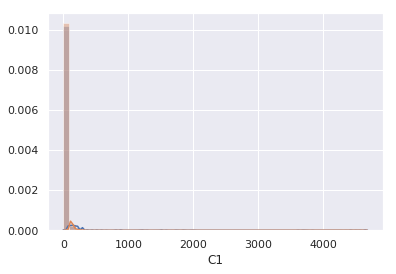

In [216]:
sns.distplot(X_subsample[y_subsample==1]['C1'])
sns.distplot(X_subsample[y_subsample==0]['C1'])

In [109]:
X_subsample['C13'].min()

0.0

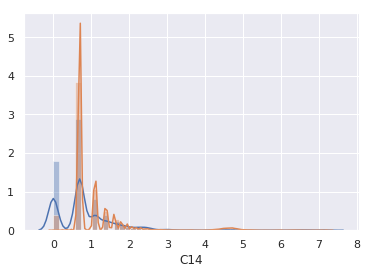

In [119]:
sns.distplot(np.log1p(X_subsample[y_subsample==1]['C14']))
sns.distplot(np.log1p(X_subsample[y_subsample==0]['C14']))

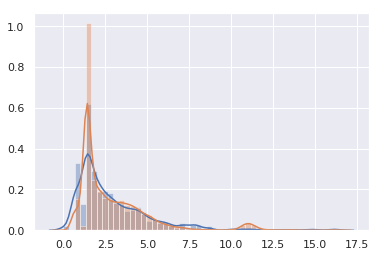

In [114]:
sns.distplot(np.log1p(X_subsample[y_subsample==1]['C13']) + np.log1p(X_subsample[y_subsample==1]['C1']))
sns.distplot(np.log1p(X_subsample[y_subsample==0]['C13']) + np.log1p(X_subsample[y_subsample==0]['C1']))

In [230]:
(X_subsample[y_subsample==0]['C1'].value_counts() / len(X_subsample[y_subsample==0]))[:10]

1.0     0.557134
2.0     0.175026
3.0     0.083963
4.0     0.044632
5.0     0.027229
6.0     0.017153
7.0     0.011277
8.0     0.008676
9.0     0.005526
10.0    0.004951
Name: C1, dtype: float64

In [231]:
(X_subsample[y_subsample==1]['C1'].value_counts() / len(X_subsample[y_subsample==1]))[:10]

1.0     0.375205
2.0     0.154384
3.0     0.082945
4.0     0.052466
5.0     0.051096
6.0     0.029384
7.0     0.020890
8.0     0.015411
10.0    0.013562
Name: C1, dtype: float64

# Add more Target_encoding

In [180]:
# FAIL

In [87]:
permut_imp_df = pd.read_csv('permut_imp_df.csv')
permut_imp_df.head()

,permut_importances,cols
0,0.347677,TransactionAmt
1,0.043620,ProductCD
2,0.050782,card1
3,0.072031,card2
4,0.000920,card3


In [93]:
useful_cols = permut_imp_df[ permut_imp_df['permut_importances'] > 0.001]['cols'].tolist()

In [94]:
#baseline
tr_data = lgb.Dataset(X_subsample[useful_cols], label=y_subsample)
vl_data = lgb.Dataset(X_valid[useful_cols], label=y_valid)  
        
estimator = lgb.train(
                lgb_params,
                tr_data,
                valid_sets = [tr_data, vl_data],
                verbose_eval = 100) 

Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.963546	valid_1's auc: 0.895558
[200]	training's auc: 0.97926	valid_1's auc: 0.906262
[300]	training's auc: 0.989719	valid_1's auc: 0.913863
[400]	training's auc: 0.995402	valid_1's auc: 0.918324
[500]	training's auc: 0.998171	valid_1's auc: 0.920534
[600]	training's auc: 0.999348	valid_1's auc: 0.92151
[700]	training's auc: 0.999795	valid_1's auc: 0.921841
[800]	training's auc: 0.999946	valid_1's auc: 0.921732
Did not meet early stopping. Best iteration is:
[800]	training's auc: 0.999946	valid_1's auc: 0.921732


In [ ]:
categorical_cols = X_subsample.select_dtypes('category').columns
X_subsample['isFraud'] = y_subsample
for col in categorical_cols:
    temp_dict = X_subsample.groupby([col])['isFraud'].agg(['mean']).reset_index().rename(
                                                        columns={'mean': col+'_target_mean'})
    temp_dict.index = temp_dict[col].values
    temp_dict = temp_dict[col+'_target_mean'].to_dict()

    X_subsample[col+'_target_mean'] = X_subsample[col].map(temp_dict)
    X_valid[col+'_target_mean']  = X_valid[col].map(temp_dict)
del(X_subsample['isFraud'])

# ProductCD
# card1 - card6
# addr1, addr2
# Pemaildomain Remaildomain
# M1 - M9

In [ ]:
# didn't work
results_categories = {}
for col in categorical_cols:
    tr_data = lgb.Dataset(X_subsample[useful_cols +[col+'_target_mean']], label=y_subsample)
    vl_data = lgb.Dataset(X_valid[useful_cols+[col+'_target_mean']], label=y_valid)  
        
    estimator = lgb.train(
                lgb_params,
                tr_data,
                valid_sets = [tr_data, vl_data],
                verbose_eval = 0) 
    print(col+'_target_mean', estimator.best_score['valid_1']['auc'])
    results_categories[col+'_target_mean'] = estimator.best_score['valid_1']['auc'] - 0.921732

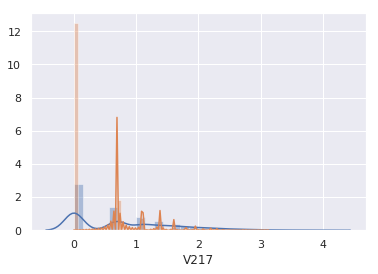

In [184]:
sns.distplot(np.log1p(X_subsample[y_subsample==1]['V217'].dropna()))
sns.distplot(np.log1p(X_subsample[y_subsample==0]['V217'].dropna()))

In [187]:
X_subsample['V217log'] = np.log1p(X_subsample['V217'] )
X_valid['V217log'] = np.log1p(X_valid['V217'] )
tr_data = lgb.Dataset(X_subsample[useful_cols + ['V217log']], label=y_subsample)
vl_data = lgb.Dataset(X_valid[useful_cols + ['V217log']], label=y_valid)  
        
estimator = lgb.train(
                lgb_params,
                tr_data,
                valid_sets = [tr_data, vl_data],
                verbose_eval = 100) 

Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.963548	valid_1's auc: 0.89261
[200]	training's auc: 0.979442	valid_1's auc: 0.90421
[300]	training's auc: 0.989825	valid_1's auc: 0.911988
[400]	training's auc: 0.995464	valid_1's auc: 0.916783
[500]	training's auc: 0.998203	valid_1's auc: 0.919495
[600]	training's auc: 0.999355	valid_1's auc: 0.920534
[700]	training's auc: 0.999804	valid_1's auc: 0.920776
[800]	training's auc: 0.999949	valid_1's auc: 0.92123
Did not meet early stopping. Best iteration is:
[800]	training's auc: 0.999949	valid_1's auc: 0.92123


### some V cols 

In [195]:
y_subsample[X_subsample[ X_subsample['V217'].isnull()].index].value_counts()

0    30614
1     7308
Name: isFraud, dtype: int64

In [200]:
y_subsample[X_subsample[ X_subsample['V217'].notnull()].index].value_counts()

0    9380
1    7292
Name: isFraud, dtype: int64

In [201]:
y_subsample[X_subsample[ X_subsample['V218'].notnull()].index].value_counts()

0    9380
1    7292
Name: isFraud, dtype: int64

In [202]:
y_subsample[X_subsample[ X_subsample['V219'].notnull()].index].value_counts()

0    9380
1    7292
Name: isFraud, dtype: int64

In [205]:
(X_subsample['V218'].notnull().index == X_subsample['V217'].notnull().index ).all()

True

In [221]:
(X_subsample[ X_subsample['V217'].notnull() ]['V218'] == X_subsample[ X_subsample['V218'].notnull() ]['V219']).mean()

0.9198656429942419

In [208]:
(X_subsample['V217'].notnull() == X_subsample['V219'].notnull()).all()

True

In [210]:
X_subsample[['V217', 'V218', 'V219']].sample(18)

,V217,V218,V219
TransactionID,,,
3101755,NaN,NaN,NaN
3391469,3.0,3.0,3.0
3365074,0.0,0.0,0.0
3075855,NaN,NaN,NaN
2994302,NaN,NaN,NaN
3342225,NaN,NaN,NaN
3182463,NaN,NaN,NaN
3319836,1.0,1.0,1.0
3002040,NaN,NaN,NaN


In [ ]:
# ideés: 
# -revoir le uid avec addr1__addr2 + ALLcards
# -revoir le uid avec addr1__addr2 + ALLcards + concatALLIDS
# -Use D columns to figure out better ways to make sure the above makes sense :
#    see https://www.kaggle.com/akasyanama13/eda-what-s-behind-d-features

# that stuff: https://www.kaggle.com/kyakovlev/ieee-fe-with-some-eda
# and here : https://www.kaggle.com/c/ieee-fraud-detection/discussion/108467#624394